In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycrs
import json
import ipywidgets as widgets
%matplotlib inline
import os
import csv
from IPython.display import display
from ipywidgets import Button, Layout
import cv2
from sklearn.cluster import MiniBatchKMeans
from webcolors import hex_to_rgb
from scipy.spatial.distance import cdist


In [2]:
df = pd.read_json('embroidery_DMC.json')
df = df.T
df.head()

,DMC Num,hex,rgb
Ecru/off-white,Ecru,#fff7e7,"[255, 247, 231]"
Antique Mauve - MED DK,315,#7d4246,"[125, 66, 70]"
White,White,#ffffff,"[255, 255, 255]"
Antique Mauve - MED,316,#bc757f,"[188, 117, 127]"
Snow White,B5200,#fcfcff,"[252, 252, 255]"


Text(value='examples/machu-picchu.png', description='Picture:', layout=Layout(width='50%'), placeholder='Pictu…

Button(description='Import Picture', style=ButtonStyle())

Your Image:


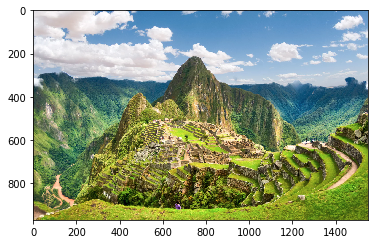

In [3]:
ref_file = widgets.Text(
    value='examples/machu-picchu.png',
    placeholder='Picture',
    description='Picture:',
    disabled=False,layout=Layout(width='50%'))


button = widgets.Button(description="Import Picture")
display(ref_file)
display(button)

def on_ref_button_clicked(b):
    print('Your Image:')
    global image
    image = cv2.imread(ref_file.value)
    destRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(destRGB)
    plt.show()
button.on_click(on_ref_button_clicked)


RadioButtons(description='Shape:', options=('Rectangle', 'Square', 'Circle'), value='Rectangle')

Button(description='Transform Options', style=ButtonStyle())

IntText(value=970, description='Diameter')

Button(description='Redisplay Image', style=ButtonStyle())

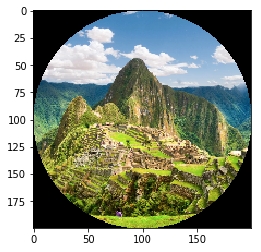

Looking Good!


In [4]:
radio = widgets.RadioButtons(
    options=['Rectangle', 'Square', 'Circle'],
    description='Shape:',
    disabled=False
)
display(radio)

button2 = widgets.Button(description="Transform Options")
display(button2)

def show_result(b):
    global image_trans
    if radio.value == 'Rectangle':
        image_trans = cv2.resize(image,(length.value,height.value))

    elif radio.value == 'Square':
        if image.shape[0]<image.shape[1]: #Height smaller than width (landscape)
            ratio = float(side_length.value)/float(image.shape[0])
            image_trans = cv2.resize(image,(int(ratio*image.shape[1]),\
                                            int(side_length.value)))
            inter_val = int(abs(image_trans.shape[0]-image_trans.shape[1])/2)
            image_trans = image_trans[:,inter_val:inter_val+side_length.value,:]
        elif image.shape[1]<=image.shape[0]: #Width smaller than height (portrait)
            ratio = float(side_length.value)/float(image.shape[1])
            image_trans = cv2.resize(image,(int(side_length.value),\
                                            int(ratio*image.shape[0])))
            inter_val = int(abs(image_trans.shape[0]-image_trans.shape[1])/2)
            image_trans = image_trans[inter_val:inter_val+side_length.value,:,:]
            
    elif radio.value == 'Circle':
        if image.shape[0]<image.shape[1]: #Height smaller than width (landscape)
            ratio = float(diameter.value)/float(image.shape[0])
            image_trans = cv2.resize(image,(int(ratio*image.shape[1]),\
                                            int(diameter.value)))
            inter_val = int(abs(image_trans.shape[0]-image_trans.shape[1])/2)
            image_trans = image_trans[:,inter_val:inter_val+diameter.value,:]
        
            mask = np.zeros((image_trans.shape[1],image_trans.shape[0]), np.uint8)
            r=int(mask.shape[0]/2)
            cv2.circle(mask,(r,r),r,(255,255,255),thickness=-1)
            image_trans = cv2.bitwise_and(image_trans, image_trans, mask=mask)
        elif image.shape[1]<=image.shape[0]: #Width smaller than height (portrait)
            ratio = float(side_length.value)/float(image.shape[1])
            image_trans = cv2.resize(image,(int(side_length.value),\
                                            int(ratio*image.shape[0])))
            inter_val = int(abs(image_trans.shape[0]-image_trans.shape[1])/2)
            image_trans = image_trans[inter_val:inter_val+side_length.value,:,:]
        
            mask = np.zeros((image_trans.shape[1],image_trans.shape[0]), np.uint8)
            r=int(mask.shape[0]/2)
            cv2.circle(mask,(r,r),r,(255,255,255),thickness=-1)
            image_trans = cv2.bitwise_and(image_trans, image_trans, mask=mask)
    destRGB = cv2.cvtColor(image_trans, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(destRGB)
    plt.show()
    print('Looking Good!')

        
        
def on_ref_button_clicked2(b):
    if radio.value == 'Rectangle':
        global length, height
        length = widgets.IntText(
            value=image.shape[1],
            description='Length',
            disabled=False)
        height = widgets.IntText(
            value=image.shape[0],
            description='Height',
            disabled=False)
        display(length)
        display(height)
        
    elif radio.value == 'Square':
        global side_length
        side_length = widgets.IntText(
            value=min(image.shape[0],image.shape[1]),
            description='Side Length',
            disabled=False)
        display(side_length)
    elif radio.value == 'Circle':
        global diameter
        diameter = widgets.IntText(
            value=image.shape[0],
            description='Diameter',
            disabled=False)
        display(diameter)
    button3 = widgets.Button(description="Redisplay Image")
    display(button3)
    button3.on_click(show_result)
    
button2.on_click(on_ref_button_clicked2)


IntText(value=10, description='Color Number')

Button(description='Color Cluster', style=ButtonStyle())

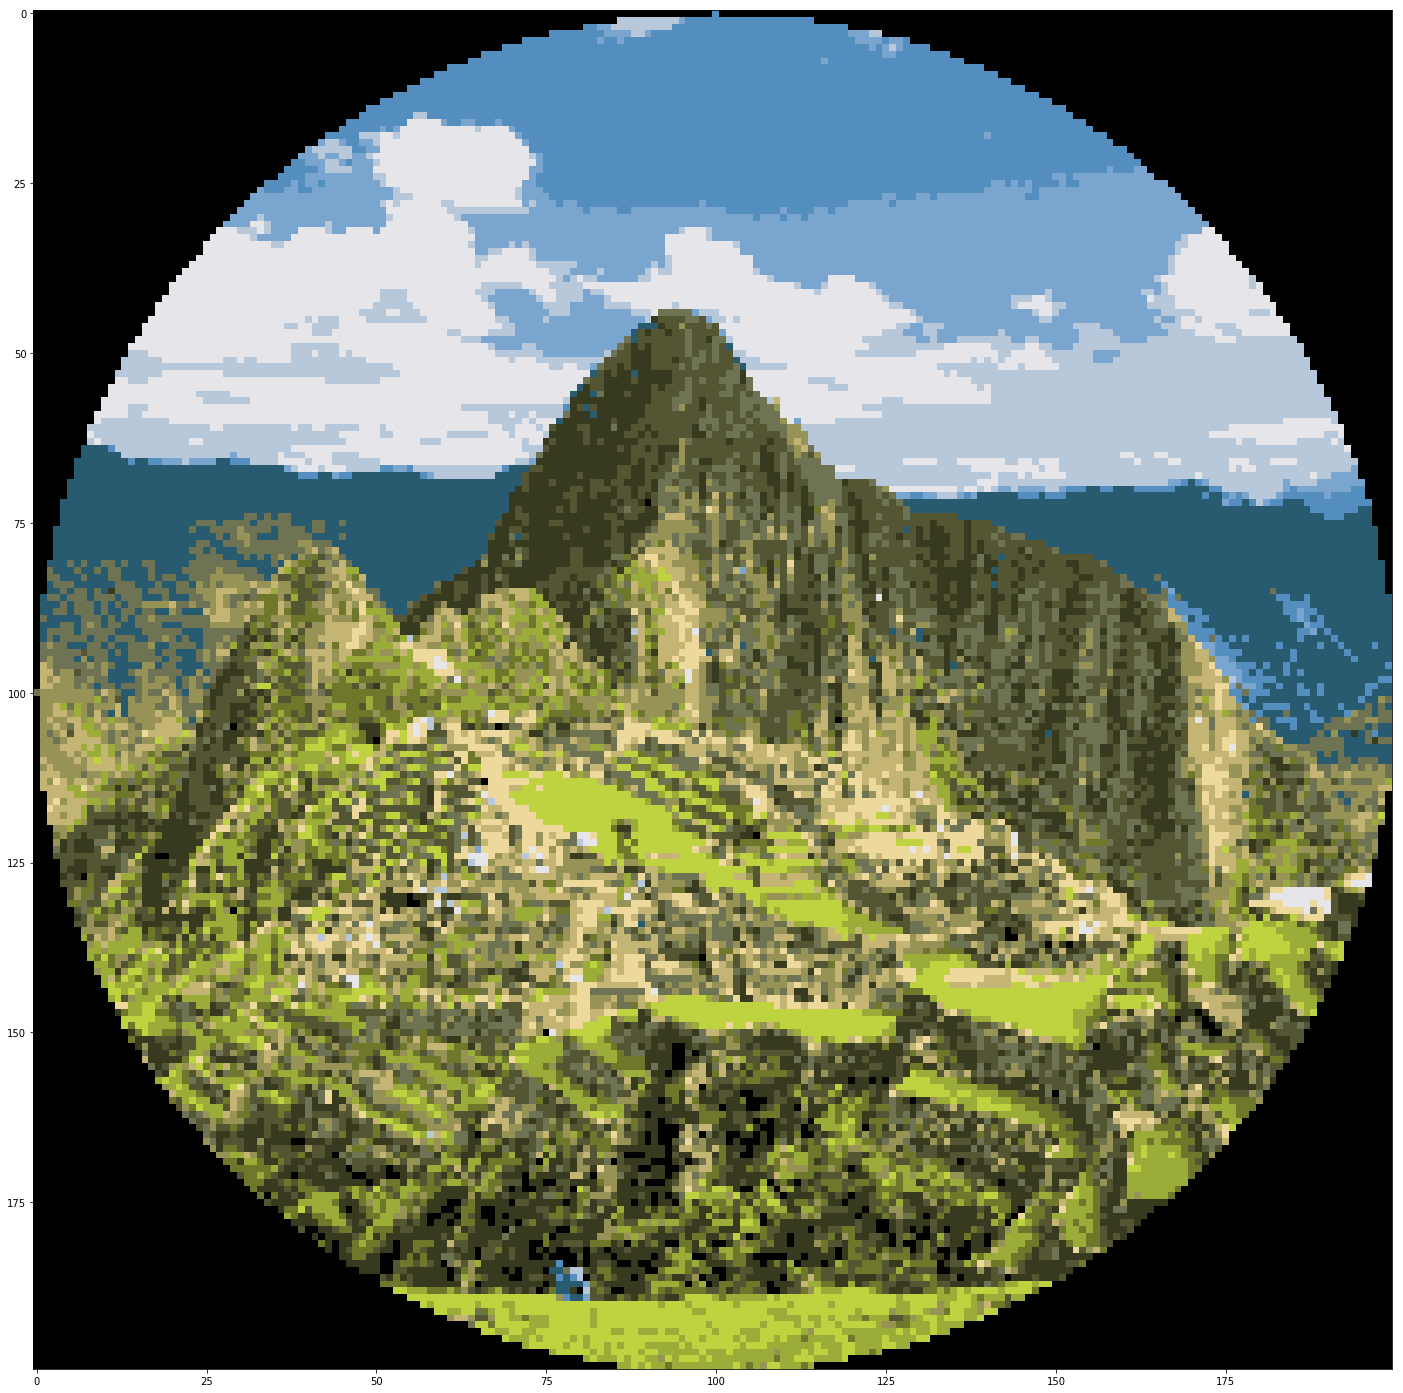

1: Black
2: Peacock Blue - VY DK
3: Avocado Green - BLACK
4: Baby Blue - MED
5: Pine Green - DK
6: Pine Green - MED
7: Avocado Green - LT
8: Blue - LT
9: Mustard
10: Lime Green
11: Sky Blue - LT
12: Lime Green
13: Yellow Beige - MED
14: Antique Blue - ULT VY LT
15: Old Gold - VY LT


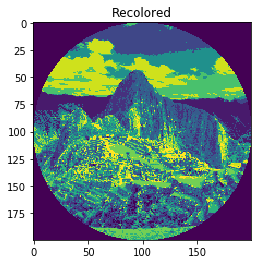

In [5]:
num_clusters = widgets.IntText(
    value=10,
    description='Color Number',
    disabled=False)


def cluster_image(b):
    K_clusters = num_clusters.value
    image = cv2.cvtColor(image_trans, cv2.COLOR_BGR2LAB)
    h,w,channels = image.shape
    # reshape the image into a feature vector so that k-means
    # can be applied
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    # apply k-means using the specified number of clusters and
    # then create the quantized image based on the predictions
    clt = MiniBatchKMeans(n_clusters = K_clusters)
    labels = clt.fit_predict(image)
    quant = clt.cluster_centers_.astype("uint8")[labels]

    # reshape the feature vectors to images
    quant = quant.reshape((h, w, 3))
    image = image.reshape((h, w, 3))

    # convert from L*a*b* to RGB
    quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)


    quant_RGB = cv2.cvtColor(quant,cv2.COLOR_BGR2RGB)
    global RGB_colors
    RGB_colors = np.unique(quant_RGB.reshape(1,quant_RGB.shape[0]*quant_RGB.shape[1],3),axis=1)

    plt.figure(figsize=(25,25))
    plt.imshow(quant_RGB)
    plt.grid(np.arange(0,image.shape[0],image.shape[0]+1))
    plt.show()

    rgb_li = []
    for i in df['rgb']:
        rgb_li.append(i)
    rgb_li = np.array(rgb_li)
    global DMC_colors
    DMC_colors = []
    for i in cdist(RGB_colors[0],rgb_li):
        f = df[list(i).index(min(list(i))):list(i).index(min(list(i)))+1]
        DMC_colors.append(f.index[0])
    for i in range(len(DMC_colors)):
        print(str(i+1)+': '+str(DMC_colors[i]))

    dim_red = quant_RGB.reshape(1,quant_RGB.shape[0]*quant_RGB.shape[1],3)[0]
    q = []
#    print(RGB_colors)
    blank = np.zeros(quant_RGB.shape[:2])
    for i in range(len(RGB_colors[0])):
#        print(RGB_colors[0][i])
        inter = np.where(quant_RGB==tuple(RGB_colors[0][i]),1,0)[:,:,0]
        blank+=(i+1)*inter
    plt.figure()
    plt.title('Recolored')
    plt.imshow(blank)
    plt.show()
    csv_write = pd.DataFrame(blank)
    csv_write.to_csv('embroider.csv')
display(num_clusters)
button4 = widgets.Button(description="Color Cluster")
display(button4)

button4.on_click(cluster_image)
